In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import acquire
import prepare
import model

# Who will churn?
---
by Kevin smith 7/15/2022

## Project Goal
---
The goal of this project is to identify indicators of churn within the Telco dataset, and deliver actionable suggestions for Telco to reduce the amount of monthly churn in the future.

This goal will be accomplished utilizing the following steps:

* Planning
* Acqusition
* Prep
* Exploration
* Feature Engineering
* Modeling
* Delivery


### Initial questions
---
* Who is churning?
* Why are they churning?
* What can be done?

## Acquisition
---
Before we can answer the questions, we have to get the data. In this case we are pulling the data from a SQL server. The we will perform a SQL query that joins the different tables together and creates a data frame.

In [2]:
# here I am calling a function to go acquire the data i need
df = acquire.get_telco_data()
# displaying the information in the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

## Prep
---
Now that we have our data we need to prep it for exploration and modeling.

What I have done is drop 11 rows that had blanks in the total charges column, and converted it into a numeric format. Then I removed columns that are clearly duplicates, and removed columns with protected classes. 

After that I created dummy columns to use when modeling later, and I split the data into <mark>train</mark>,<mark>validate</mark>, and <mark>test</mark> DataFrames as well as generating a <mark>dummy_list</mark> for later use.

In [3]:
# calling a function to clean and tidy my DataFrame and split it into 3 DataFrames to account for data leakage.
train,validate,test,dummy_list = prepare.prep_telco(df)
train.columns

Index(['customer_id', 'tenure', 'phone_service', 'multiple_lines',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'paperless_billing',
       'monthly_charges', 'total_charges', 'churn', 'contract_type',
       'internet_service_type', 'payment_type', 'paperless_billing_Yes',
       'online_security_No internet service', 'online_security_Yes',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes',
       'streaming_movies_No internet service', 'streaming_movies_Yes',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'phone_service_Yes', 'tech_support_No internet service',
       'tech_support_Yes', 'contract_type_One year', 'contract_type_Two year',
       'internet_service_type_Fiber optic', 'internet_service_type_None',
       'payment_type_Cred

## Exploration
---
This is where we start asking our questions and seeing what the data says.

The first question we really need to answer is **Who is churning?**

The data shows that 2 categories are far more likely to churn than anyone else. **Month-to-Month** contracts, and **E-check payments**.

**26%** of the customers in the train data set churn. Of that 26% nearly all of those customers are on month-to-month contracts. This means that the month-to-month option is enticing to new customers, but for some reason almost half of them end up not staying with the company.

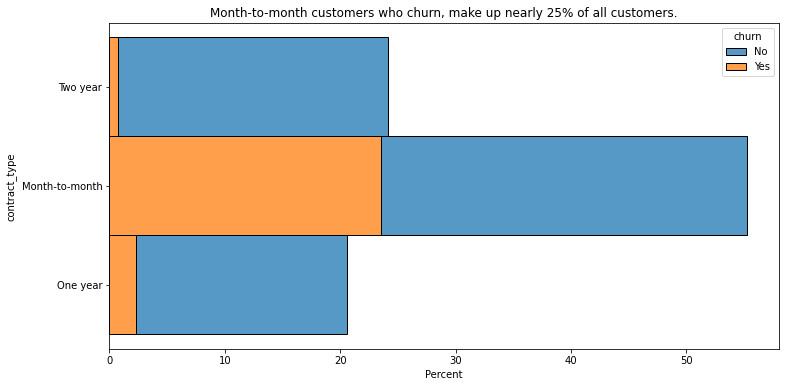

In [4]:
# visualizing percentages of churn in different contract types.
plt.figure(figsize=(12, 6))
sns.histplot(data=train, y='contract_type',multiple='stack', stat='percent',hue='churn')
plt.title("Month-to-month customers who churn, make up nearly 25% of all customers.")
plt.show()

As we can see in the chart, month-to-month is our most popular contract type, but it also has the highest rate of churn. 

we might be tempted to discontinue this option, but that would likely cause worse issues.

The next question we can ask is **are they leaving because they're paying more?**

Yes, they are paying slightly, more. However that could be due to the popularity of Fiber Optic internet driving up the average price. 

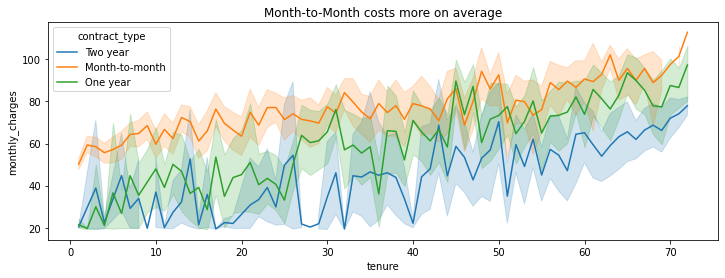

In [5]:
# visualizing monthly charges over time by contract type
plt.figure(figsize=(12, 4))
sns.lineplot(data=train, y='monthly_charges',x='tenure',hue='contract_type')
plt.title('Month-to-Month costs more on average')
plt.show()

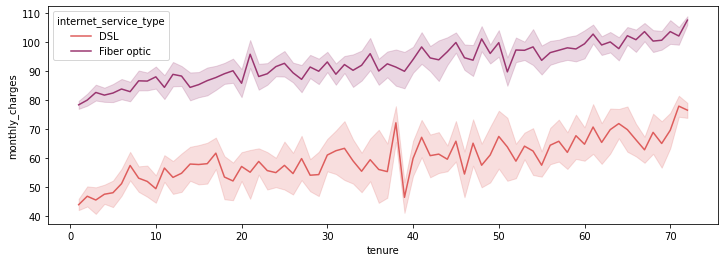

In [6]:
# visualizing the cost of different internet services over time
plt.figure(figsize=(12, 4))
sns.lineplot(data=train.where(train.internet_service_type!='None'), y='monthly_charges',x='tenure',hue='internet_service_type', palette='flare')
plt.show()

The charts above show that people on Month-to-month contracts do tend to pay more, but it is likely because of the price difference between DSL and Fiber Optic internet.

The next question is **does payment type play a role in churn?**

In a word, **Yes**

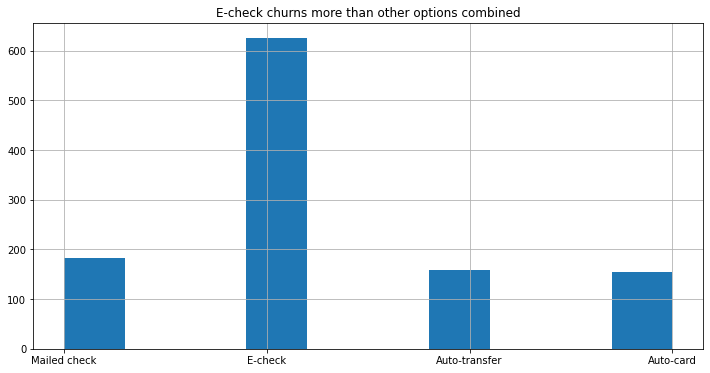

In [7]:
# visualization of churn in payment types
plt.figure(figsize=(12, 6))
train.payment_type.where(train.churn == 'Yes').hist()
plt.title('E-check churns more than other options combined')
plt.xticks([0,1,2,3],['Mailed check','E-check','Auto-transfer','Auto-card'])
plt.show()

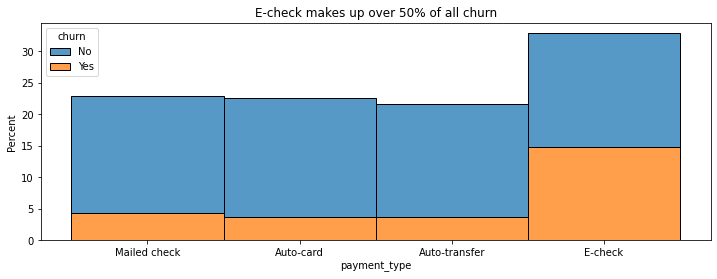

In [8]:
# visualization of what percentage a payment type makes up of all the train data VS 
# the percentage of those payment types that churn
plt.figure(figsize=(12, 4))
sns.histplot(data=train, x='payment_type',multiple='stack', stat='percent',hue='churn')
plt.xticks([0,1,2,3],['Mailed check','Auto-card','Auto-transfer','E-check'])
plt.title('E-check makes up over 50% of all churn')
plt.show()

As you can see, although E-check is slightly more popular than other forms of payment, it makes up a disproportionate amount of churn. Accounting for over 30% of the overall customer population, but making up over half of the customers who churn.

This could be indicitive of an issue with the E-check process if **nearly half** of the customers who pay this way churn.

Do customers who pay by E-check pay more?
**No**. However, the other less convenient payment type (<mark>mailed check</mark>) tends to pay less **and** churn less.

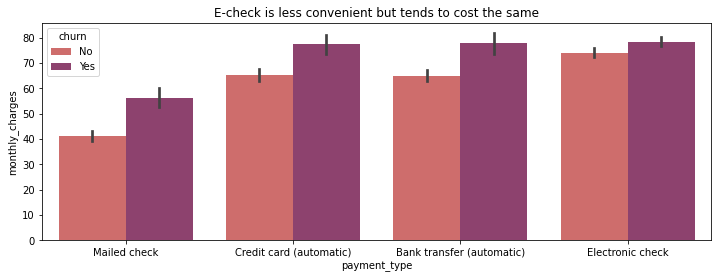

In [9]:
# visualizing the average monthly cost per payment type
plt.figure(figsize=(12, 4))
sns.barplot(data=train, y='monthly_charges',x='payment_type',hue='churn', palette='flare')
plt.title('E-check is less convenient but tends to cost the same')
plt.show()

## Hypothesis Testing
---
All the questions that we asked and answered above are great starting points for things we can do to fix the churn issue, but how can we really be confident about what we know kabout the data?

The answer is statistical analysis! 

Don't worry. I wont make you sit through a step by step of how I did it, but I have created a function that goes through each column in the data and evaluates how confident we can be that it can be used to predict churn. 

This function performed a statistical analysis based on the type of data in the column and then gives me a list of columns that are either very important, or are not statistically important when determining probability of churn.

I dropped <mark>customer_id, phone_service, and total_charges</mark>

total_charges being lower for people who churn confirms the most people churn early in tenure.

In [10]:
# looping through a chi^2 test for each of the object data types,
# then a 1 tailed T-test for the numeric types that point different directions based on
# which numeric data type it is.

prepare.important_variables(train)

customer_id and churn are NOT dependent.
tenure is LOWER for people who churn. Confidence level: 1.0
phone_service and churn are NOT dependent.
monthly_charges is HIGHER for people who churn. Confidence level: 1.0
total_charges is NOT HIGHER for people who churn.


## Modeling
---
In my <mark>messy_notebook.ipynb</mark> file I walk through my process of how I selected the model I used if you'd like a better look into how this model was chosen.

Below we quickly run through the **Random Forest** machine learning model. Which essentially finds the most efficient questions to ask the data when making a prediction, and then asks those questions many times to verify that those questions consistently produce results.

I optimized for accuracy.

In [11]:
# dropping unimportant columns
train = train.drop(columns=['phone_service_Yes','total_charges'])
validate = validate.drop(columns=['phone_service_Yes','total_charges'])
test = test.drop(columns=['phone_service_Yes','total_charges'])

# dropping the dummy list
train = train.drop(columns=dummy_list)
validate = validate.drop(columns=dummy_list)
test = test.drop(columns=dummy_list)
    
# splitting the train, validate, and test DataFrames into objects that can be fit to our model
x_train = train.drop(columns=['churn','customer_id'])
y_train = train.churn

x_validate = validate.drop(columns=['churn', 'customer_id'])
y_validate = validate.churn

x_test = test.drop(columns=['churn', 'customer_id'])
y_test = test.churn

# fitting the objects to the model and making predicitons
RF1 = RandomForestClassifier(min_samples_leaf= 10, max_depth=10, random_state = 123)
RF1.fit(x_train,y_train)
y_pred = RF1.predict(x_train)

# generating scores
train_score = RF1.score(x_train,y_train)
validate_score = RF1.score(x_validate, y_validate)
test_score = RF1.score(x_test,y_test)

# printing accuracy scores
print(f'Train: {train_score}, Validate: {validate_score}, Test: {test_score}')

Train: 0.8186344238975818, Validate: 0.7867803837953091, Test: 0.8052594171997157


## Delivery
---
In conclusion, we can consistently predict churn with accuracy in the high 70's to low 80's. Which is great, but how do we actually bring churn down?
### Suggestions
---
1. Offer a 5-10% discount for signing up for one of the automatic pay functions
2. Offer a 1 time discount to anyone predicted to churn, in exchange for filling out a survey
3. Re-evaluate the E-check payment process to discover if a better process would alleviate churn